In [4]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import xarray as xr
try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

/tmp/ipykernel_1989662/3555279312.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
def check_hfc(species):
    """Check if the species is an HFC and remove the hyphen"""
    if "HFC-" in species:
        sp_in = species.replace("-", "")
    else:
        sp_in = species
    return sp_in

def agage_emissions(species):
    """Read AGAGE emissions data for a given species"""
    py_path = f"/user/home/lw13938/work/py12box_agage/data/{species}/outputs/{species}_Global_annual_emissions.csv"
    em_csv = pd.read_csv(py_path, comment="#",index_col=False)
    index = em_csv['Decimal_date'].values.astype(int)
    data = em_csv['Global_annual_emissions'].values
    data[data < 0.] = 0.0
    sp_in = check_hfc(species)
    df = pd.DataFrame(index=index, data=data)
    df.index.name = "Component"
    df.columns = [sp_in]
    return df

def agage_mf(species):
    """Read AGAGE mole fractions data for a given species"""
    py_path = f"/user/home/lw13938/work/py12box_agage/data/{species}/outputs/{species}_Global_annual_mole_fraction.csv"
    mf_csv = pd.read_csv(py_path, comment="#",index_col=False)
    index = mf_csv['Decimal_date'].values.astype(int)
    data = mf_csv['Global_annual_mole_fraction'].values
    sp_in = check_hfc(species)
    df = pd.DataFrame(index=index, data=data)
    df.index.name = "Component"
    df.columns = [sp_in]
    return df

def zero_mf(species):
    """Create a DataFrame of zeros for a given species"""
    sp_in = check_hfc(species)
    dfc = pd.DataFrame(index=emi_input.index, columns=[sp_in], data=0)
    dfc.index.name = "Component"
    return dfc

test_data_dir = "/user/home/lw13938/work/ciceroscm/tests/test-data/"

In [6]:
# Read gas parameters
gaspam = read_components("/user/home/lw13938/work/ciceroscm/inputfiles/gases_WMO2022.txt")
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')

# These are all the gases that are considered. Can add more if available or needed.
groups = {"all":[],
          "CFCs": ["CFC-11", "CFC-12", "CFC-113", "CFC-114", "CFC-115","CFC-13"],
          "HCFCs": ["HCFC-22", "HCFC-141b", "HCFC-142b", "HCFC-124", "HCFC-133a"],
          "HFCs": ["HFC-23", "HFC-32", "HFC-134a", "HFC-143a", "HFC-125",
                   "HFC-152a", "HFC-4310mee", "HFC-227ea", "HFC-365mfc",
                   "HFC-236fa", "HFC-245fa"], 
          "Solvents": ["CCl4", "CH3CCl3"],
          "PFCs":["CF4", "C2F6", "C3F8", "C4F8", "C4F10","C6F14"],
          "Other":["SF6", "NF3","SO2F2"],
          "Halons": ["H-1301", "H-2402", "H-1211", "CH3Br"]}

sp_all = combined_list = [item for sublist in groups.values() for item in sublist]

# Add missing emissions and update with AGAGE numbers where available
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
        
for sp in sp_all:
    if sp not in emi_input.columns and sp.replace("-","") not in emi_input.columns:
        df_sp = agage_emissions(sp).reindex(emi_input.index, fill_value=0)
        emi_input = pd.concat([emi_input, df_sp], axis=1)    
        # dfc_sp = zero_mf(sp).reindex(emi_input.index, fill_value=0)
        dfc_sp = agage_mf(sp).reindex(emi_input.index, fill_value=0)
        df_ssp2_conc = pd.concat([df_ssp2_conc, dfc_sp], axis=1)
    else:
        df_sp = agage_emissions(sp)
        sp_in = check_hfc(sp)
        emi_input[sp_in].update(df_sp[sp_in])
        df_sp = agage_mf(sp)
        df_ssp2_conc[sp_in].update(df_sp[sp_in])
df_ssp2_conc = df_ssp2_conc.fillna(0)


/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_gas = pd.read_csv(filename, delim_whitespace=True, index_col=0)
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:98: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_input = pd.read_csv(
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:98: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_input = pd.read_csv(
/tmp/ipykernel_1989662/21576183.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inte

In [21]:
# def calc_beta(mol_mass):
#     """Calculate the beta value for a given molecular mass"""
#     return 1.7758620689655172e8 * mol_mass * 1e-9

# df_rf = pd.read_csv("/user/home/lw13938/Python/bm_plots/Jens_RF_file/radiative_efficiency.updated.csv", comment="#")
# rf_dict = {}
# for gi, gas in enumerate(df_rf["Species"].values):
#     rf_dict[gas] = df_rf["Recommended Adjusted Effective Radiative Efficiency (W/m2/ppX)"].values[gi]

# sp_all = combined_list = [item for sublist in groups.values() for item in sublist]

# # Add the extra species
# df_si = pd.read_csv("work/py12box/py12box/data/inputs/species_info.csv", index_col=0)
# for sp in sp_all:
#     sp_in = check_hfc(sp)
#     mol_mass = df_si.loc[sp]["Molecular mass (g/mol)"]  
#     lifetime = df_rf.loc[df_rf["Species"] == sp]["WMO (2022) Total Lifetime (years)"].values
#     if sp not in gaspam.index and sp.replace("-","") not in gaspam.index:
#         gaspam = pd.concat((gaspam, pd.DataFrame(index=[sp_in], data= {"EM_UNIT":"Gg", "CONC_UNIT":"ppt", "BETA":calc_beta(mol_mass), "ALPHA":rf_dict[sp]*1e-3, "TAU1":lifetime, "TAU2":0, "TAU3":0, "NAT_EM":0.0, "SARF_TO_ERF":1.0})))
#     else:
#         gaspam.loc[sp_in] = {"EM_UNIT":"Gg", "CONC_UNIT":"ppt", "BETA":calc_beta(mol_mass), "ALPHA":rf_dict[sp]*1e-3, "TAU1":lifetime, "TAU2":0, "TAU3":0, "NAT_EM":0.0, "SARF_TO_ERF":1.0}
gaspam

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
CO2,Pg_C,ppm,2.123000,0.000000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780000,0.000000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810000,0.000000,109.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000000,0.000000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,24.394804,0.000299,52.00,0,0,0.0,1.000000
CFC-12,Gg,ppt,21.472659,0.000358,102.00,0,0,0.0,1.000000
CFC-113,Gg,ppt,33.275464,0.000302,93.00,0,0,0.0,1.000000
CFC-114,Gg,ppt,30.353034,0.000315,189.00,0,0,0.0,1.000000
CFC-115,Gg,ppt,27.431031,0.000247,540.00,0,0,0.0,1.000000
CH3Br,Gg,ppt,16.860034,0.000004,0.80,0,0,0.0,1.000000


In [ ]:
# Write emi_input as a tab spaced text file
# emi_input.to_csv('/user/home/lw13938/work/ciceroscm/inputfiles/AGAGE_em.txt', sep='\t', index=True)
# read_inputfile('/user/home/lw13938/work/ciceroscm/inputfiles/AGAGE_em.txt')
# df_ssp2_conc.to_csv('/user/home/lw13938/work/ciceroscm/inputfiles/AGAGE_conc.txt', sep='\t', index=True)

/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:98: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_input = pd.read_csv(
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:98: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_input = pd.read_csv(
/tmp/ipykernel_1989662/2889647035.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


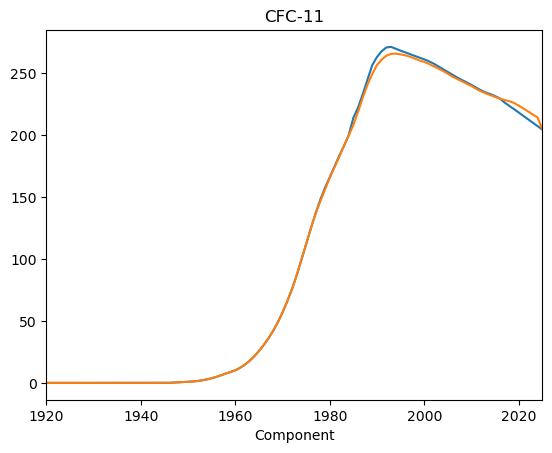

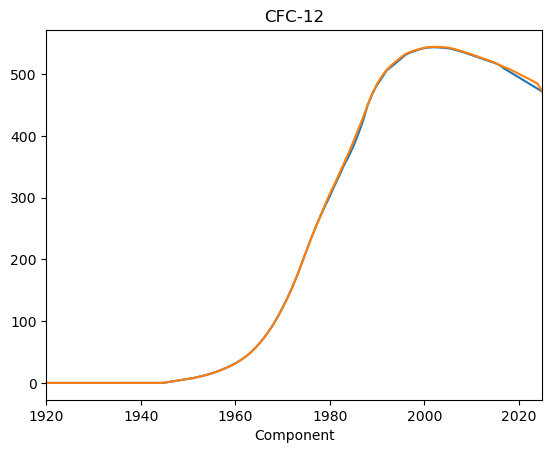

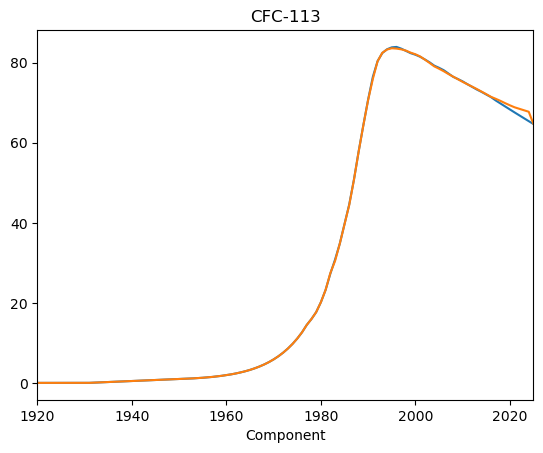

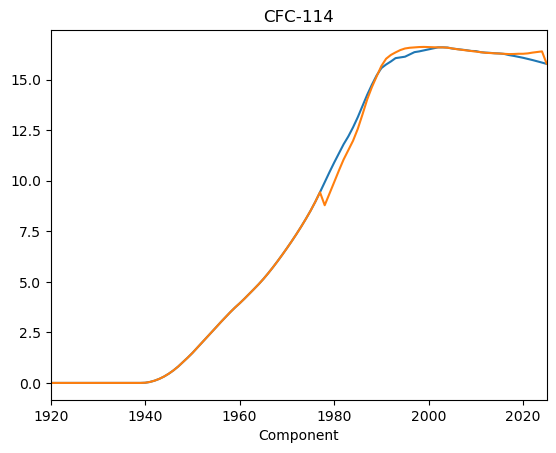

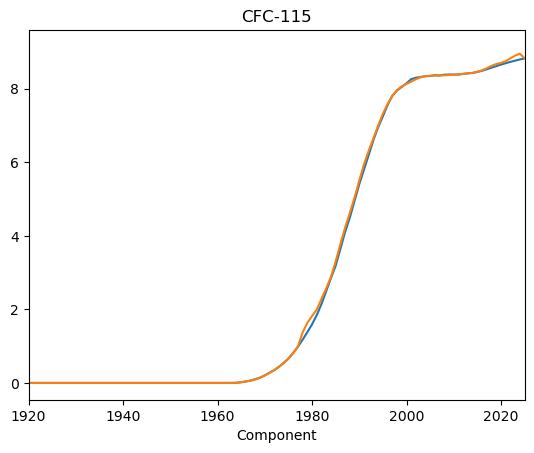

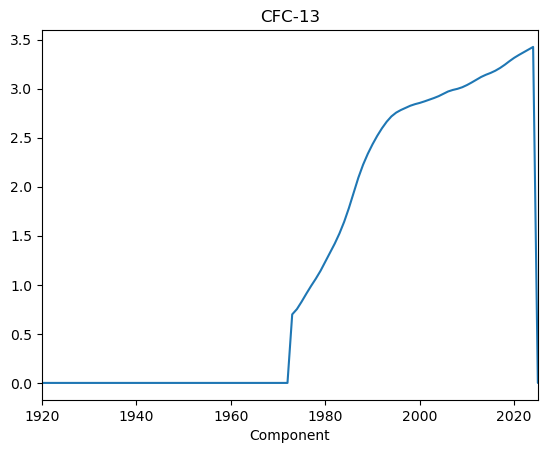

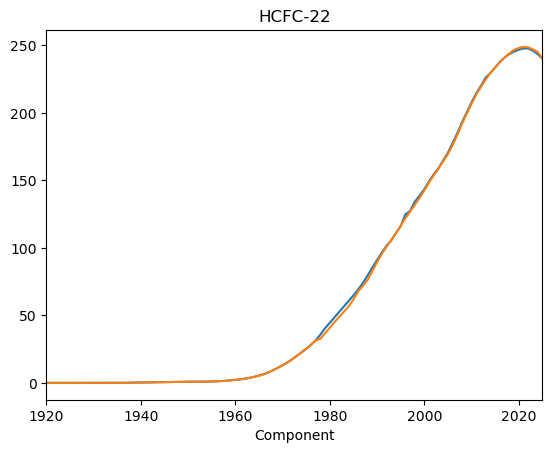

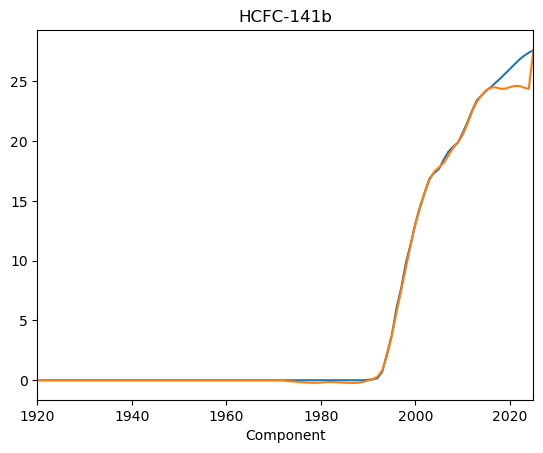

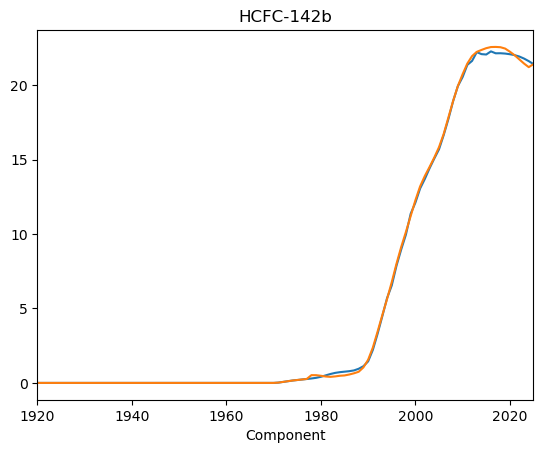

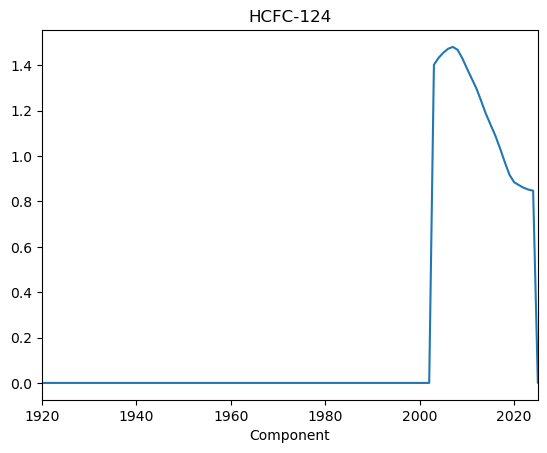

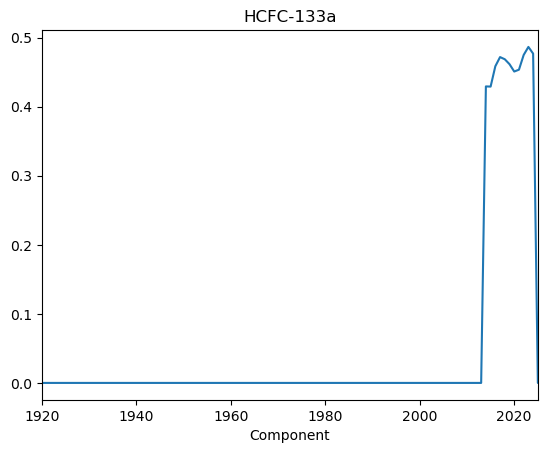

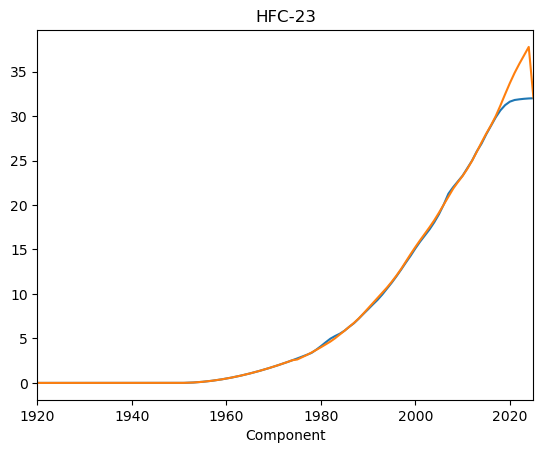

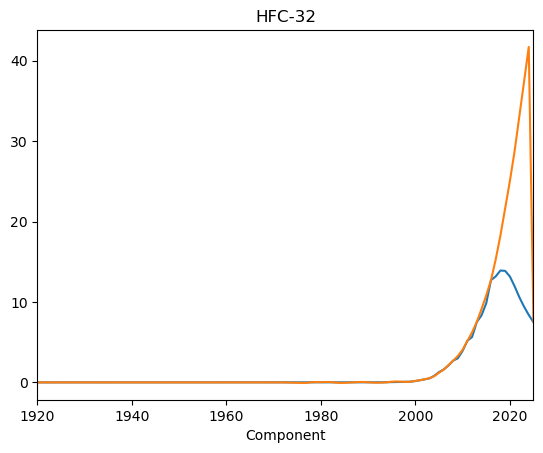

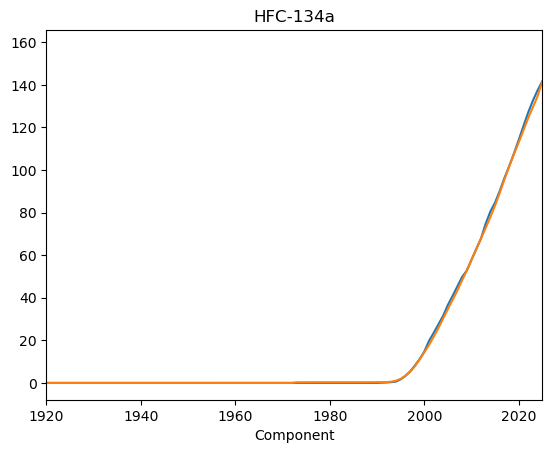

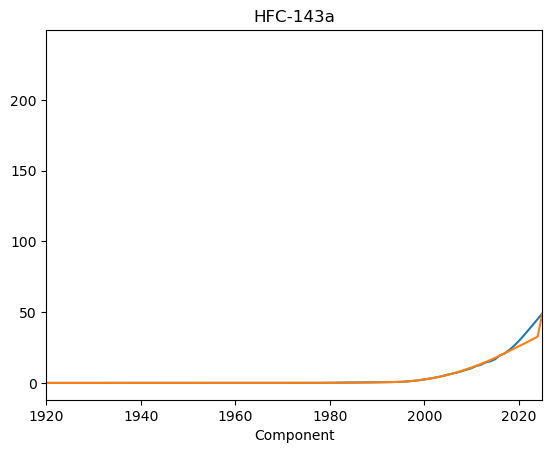

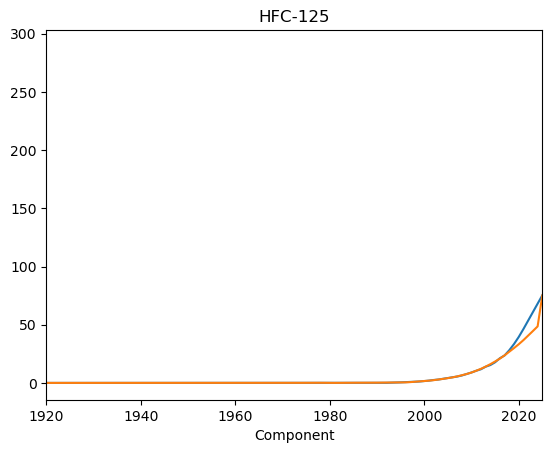

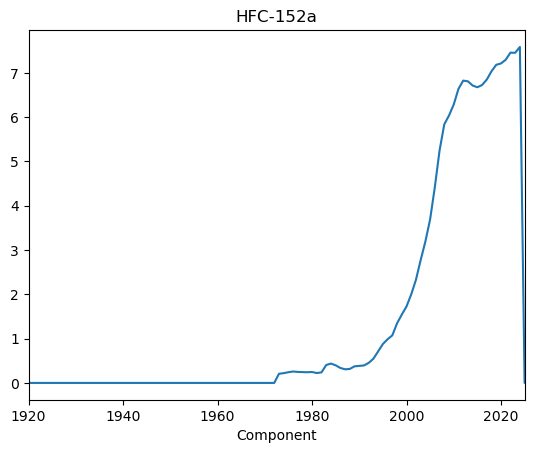

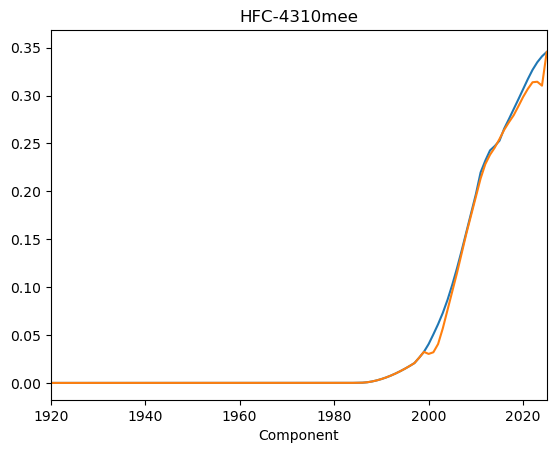

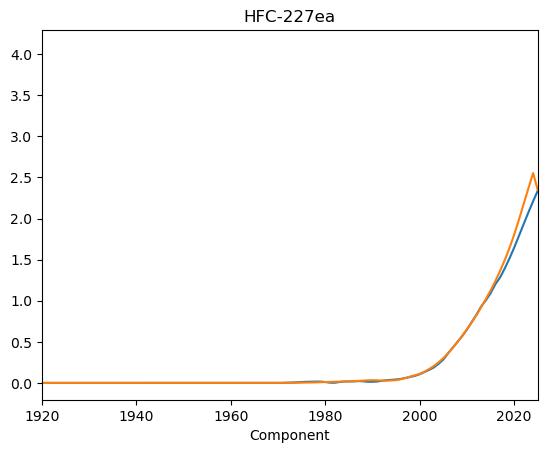

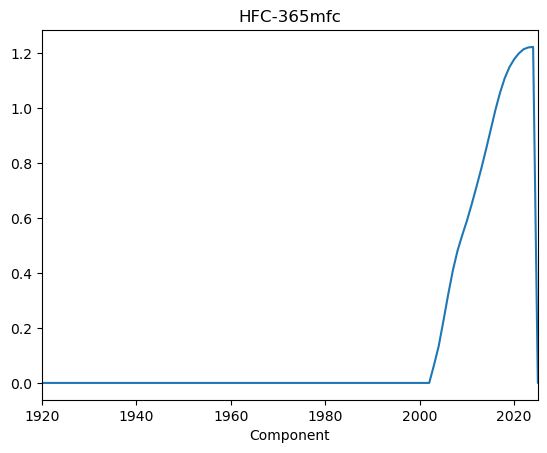

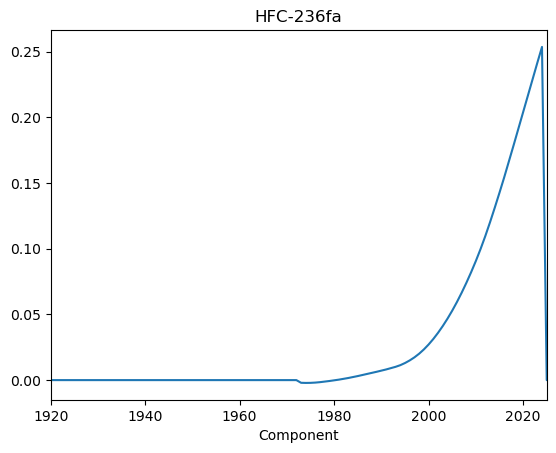

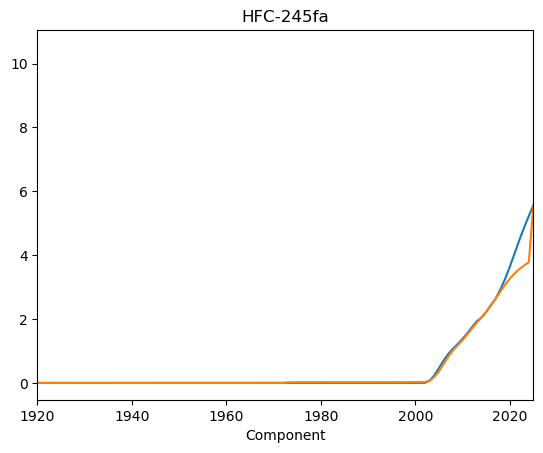

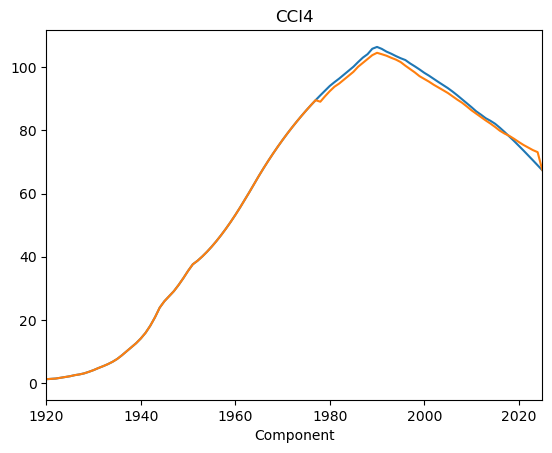

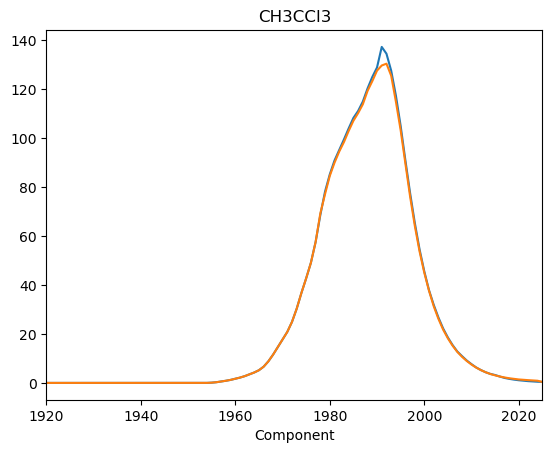

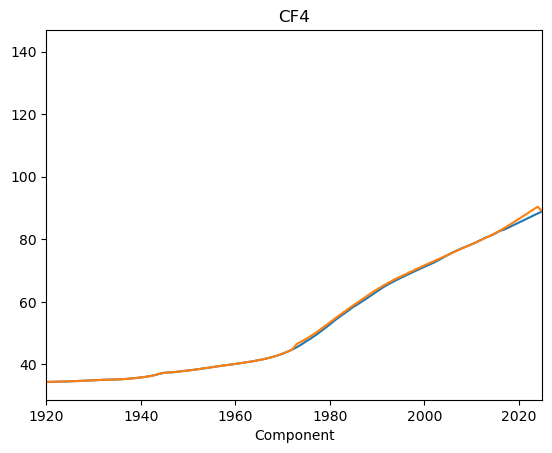

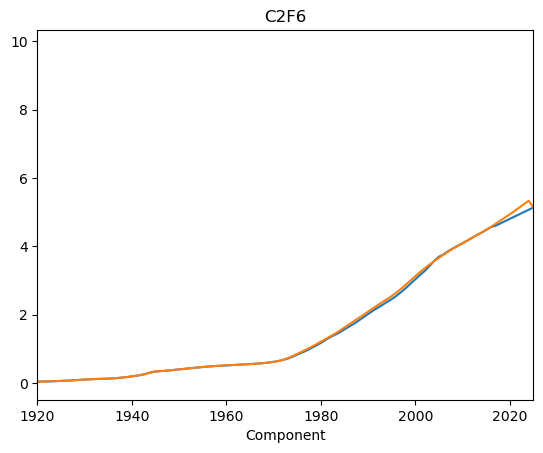

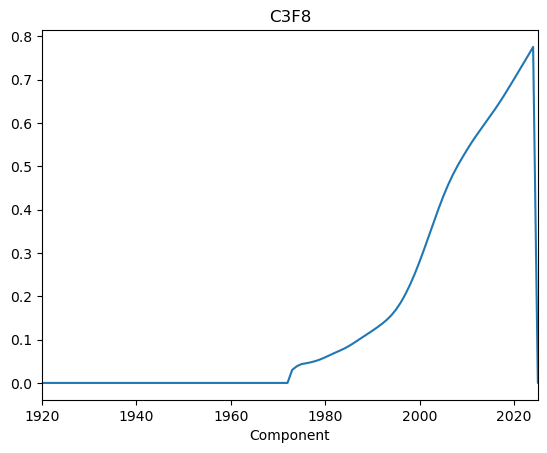

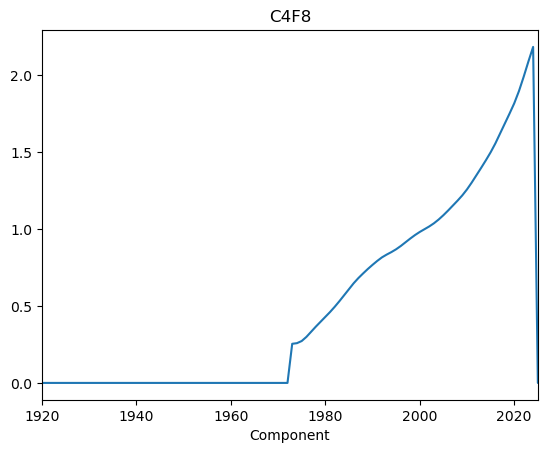

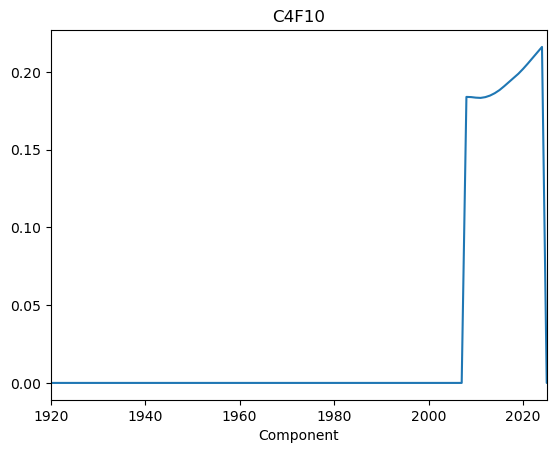

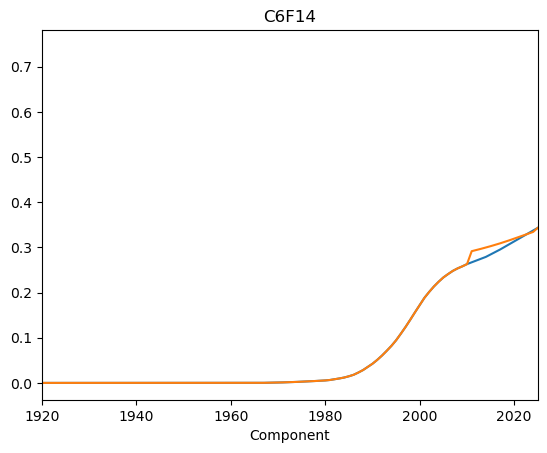

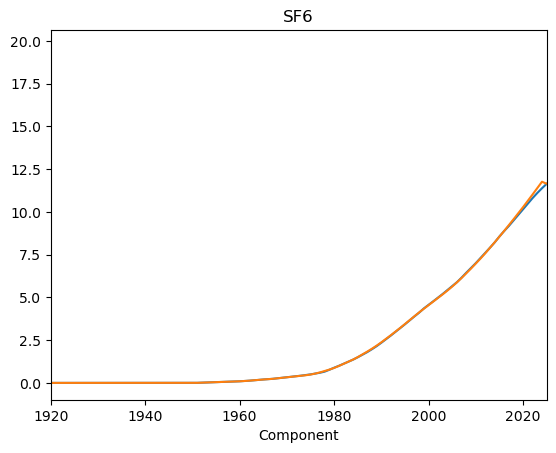

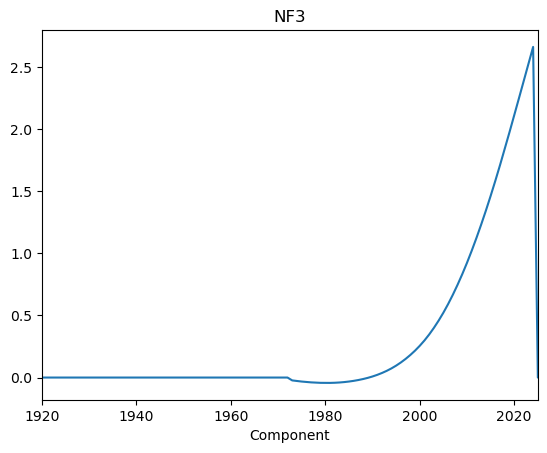

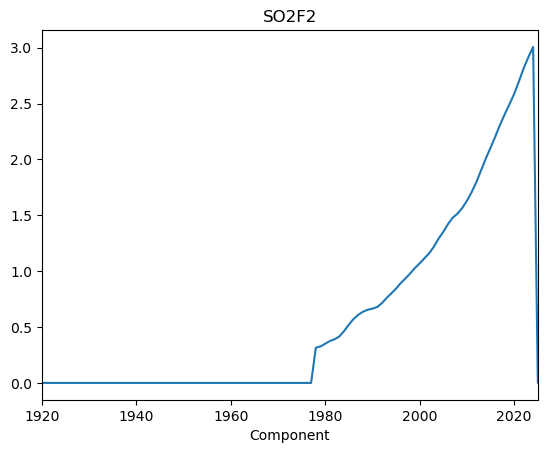

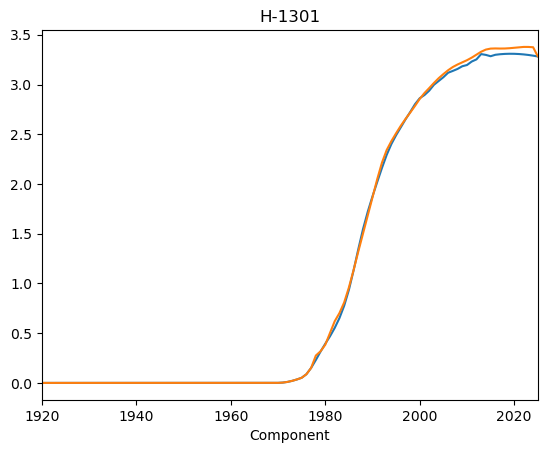

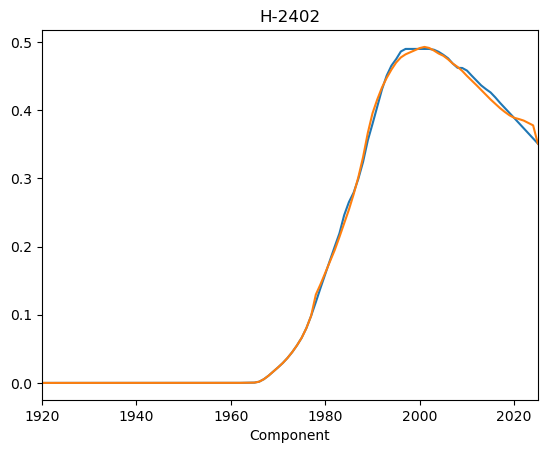

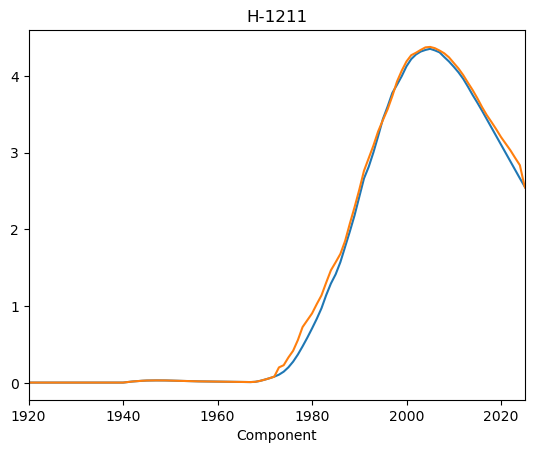

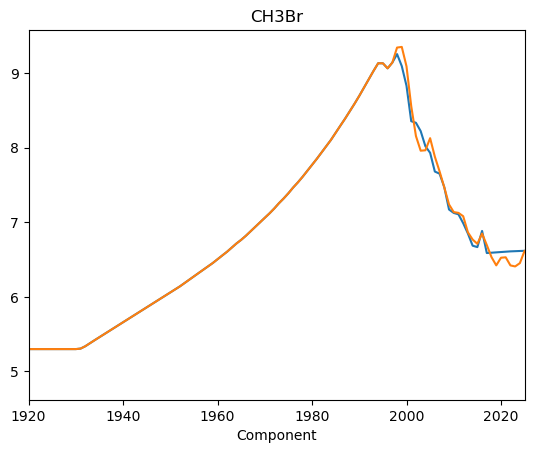

In [ ]:
# df_ssp2_conc0 =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
# df_ssp2_conc =read_inputfile('/user/home/lw13938/work/ciceroscm/inputfiles/AGAGE_conc.txt')
# for sp in sp_all:
#     plt.figure()
#     sp_in = check_hfc(sp)
#     if sp_in in df_ssp2_conc0.columns:
#         df_ssp2_conc0[sp_in].plot()
#     df_ssp2_conc[sp_in].plot()
#     plt.xlim(1920,2025)
#     plt.title(sp)
    